In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from qmlbo import signals, models, spectrum

### Generate data for Figure 5

In [6]:
def as_state(x):
    return np.array(x) / np.linalg.norm(x, ord=2)


def make_flat_state(n_q):
    return as_state(np.ones(2 ** n_q))


def create_hat_state_params(n_0, dim, a):
    """Return the parameters of a hat state computed from n_0, dim, and a.
    
    Args:
        n_0: The number of frequencies in the target function spectrum.
        dim: The dimension of the state.
        a: The _squared_ amplitude of the hat.
    """

    # This computation requires a few restrictions
    assert 0 <= a <= 2/(n_0 + 1)
    assert (n_0 + 1) % 4 == 0
    assert dim % 2 == 0


    # Derive some parameters fixed by input parameters
    n_0_bandlimit = (n_0+1) // 2
    b = (1 - n_0_bandlimit * a) / (dim - n_0_bandlimit)
    c1 = dim//2 - (n_0 + 1)//4
    c2 = dim//2 + (n_0 + 1)//4

    return b, c1, c2


def make_hat_state(n_0, dim, a):
    """Create a d-dimensional state with a hat in the interval [c1, c2).

    The wavefunction has the following shape as indexed by k:

      sqrt(a)_ _ _ _ _ _ _ __________
                           |        |
      sqrt(b)_ _ _ _ ______|        |_______
                    0      c1        c2    d-1


    where `b` is determined by a and d, and c1, c2 are given by

        c1 = d/2 - (n_0 + 1)/4
        c2 = d/2 + (n_0 + 1)/4
    
    marking the lower (inclusive) and upper (exclusive) interval boundaries.

    Args:
        n_0: The number of frequencies in the target function spectrum.
        dim: The dimension of the state.
        a: The _squared_ amplitude of the hat.
    """

    # Derive some parameters fixed by input parameters
    b, c1, c2 = create_hat_state_params(n_0, dim, a)

    out = np.ones(dim) * np.sqrt(b)
    for j in range(c1, c2):
        out[j] = np.sqrt(a)
    return out


def hat_state_nu_analytical(n_0, d, a):
    """Analytical formula for the optimal nu corresponding to a hat state."""
    b, c1, c2 = create_hat_state_params(n_0, d, a)

    out = np.zeros(2*d - 1)

    for k in range(d):
        term = None
        if 0 <= k < (c2 - c1):
            term = (c1 + d - c2 - 2*k) * b ** 2 + 2*k*a*b + (c2 - c1 - k) * a ** 2
        elif (c2 - c1) <= k < c1:
            term = (d + 2*c1 - 2*c2 - k) * b ** 2 + 2 * (c2 - c1) * a*b
        elif c1 <= k < c2:
            term = (c1 - c2 + k) * b ** 2 + (d + (c2-c1) - 2*k) * a*b
        elif c2 <= k < d:
            term = (d - k) * b ** 2
        if term is None:
            raise ValueError
        out[k + d - 1] = term

    out[0:d-1] = out[d:][::-1]

    return out

In [7]:
# Plot error behavior as a function of d for fixed n
n_0 = 15 # size of the signal band
SIGMA_SQ = 0.4
SIGMA = np.sqrt(SIGMA_SQ)
POWER = 0.6
n_fixed = 31
SIGNAL_FOURIER_COEFFICIENTS = np.ones(n_0) * np.sqrt(POWER / n_0)
dim_arr = np.arange(n_0+2, 601, 2)


def signal(times, sigma):
    return signals.signal_from_fourier_coefficients(times, fcoeffs=SIGNAL_FOURIER_COEFFICIENTS, sigma=sigma)


# Run an "experiment" with `n` time samples
time_samples = np.linspace(0, 1-1/n_fixed, n_fixed) # this gives dx = 1/n. i.e. x = (0, 1/n, ..., (n-1)/n)
M = 90
timesteps = M * n_fixed
time_continuous = np.linspace(0, 1, timesteps)
noiseless_f_sampled = signal(time_samples, sigma=0) # noiseless samples

def demo_signal(times, sigma=SIGMA):
    demo_weights = np.sqrt(POWER) * np.array([0, 1/np.sqrt(2), 0, 0, 0, 1/np.sqrt(2), 0])
    return signals.signal_from_fourier_coefficients(times, fcoeffs=demo_weights, sigma=sigma)

In [8]:
# Toggle this if you want to change the plots without re-running experiments
# First time running this notebook, you will need to set this to True
# Runtime was about 2 minutes on a Intel Xeon CPU E3-1230 v6 @ 3.50GHz
RUN_EXPERIMENTS = False

n_arr = np.arange(17, 601, 20)
m_arr_lst = [
    (r"$d\sim n$", 2 * np.ones_like(n_arr)), # linear, odd dimensions
    (r"$d\sim n^2$", 2 * n_arr),
]
weights_lst = []
assert min(n_arr) >= n_0

# Gather experimental and analyitical error terms for the model
# indexed as (bias, var), n, m, state_scheme
ana_errors = np.zeros((2, len(n_arr), len(m_arr_lst), 2))
a = 1.7 / (n_0 + 1) # hat top

if RUN_EXPERIMENTS:
    for k, (_, m_arr) in enumerate(m_arr_lst):
        for j, (n, m) in enumerate(zip(n_arr, m_arr)):
            for ell in range(2):

                d = n * (m + 1)
                state_dim = 2* (d + 1)
                sampled = signal(np.linspace(0, 1 - 1/n, n), sigma=0)
                if ell == 0:
                    nus = hat_state_nu_analytical(n_0, state_dim, a)
                    weights = np.sqrt(nus)
                elif ell == 1:
                    weights = signals.binary_triangle_weights(d=d)
                bias2, var = signals.compute_bias2_var(sampled, weights, SIGMA)
                ana_errors[0,j,k,ell] = bias2
                ana_errors[1,j,k,ell] = var   
    np.save("general_quantum_model_bo_ana_errors.npy", ana_errors)
else:
    ana_errors = np.load("general_quantum_model_bo_ana_errors.npy")


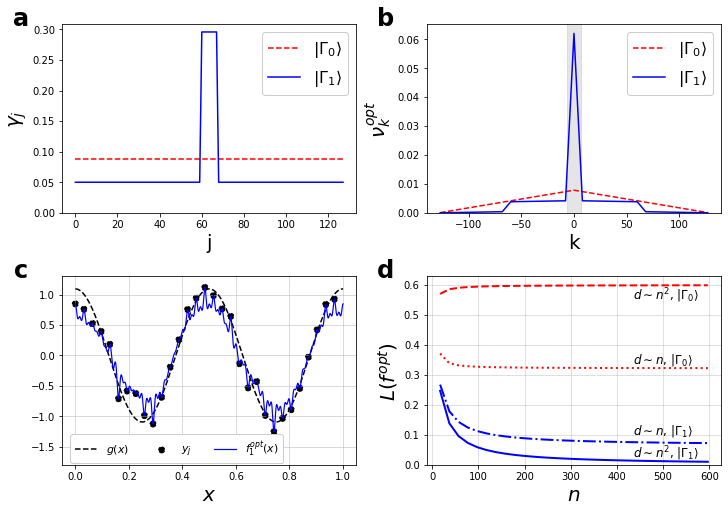

In [9]:
fig = plt.figure(figsize=(10, 7), constrained_layout=True)
gs = GridSpec(2, 2, figure=fig)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,1])
ax3 = fig.add_subplot(gs[1,0])

xlab_size = 20
ylab_size = 20

demo_dim = 128
demo_nqubits = int(np.log2(demo_dim))
demo_a = 1.4 / (n_0 + 1) # hat top
demo_nus = hat_state_nu_analytical(n_0, demo_dim, demo_a)
demo_freqs = np.arange(-demo_dim + 1, demo_dim, 1)

# Plot the input state profile
demo_gamma = make_hat_state(n_0, demo_dim, demo_a)
flat_gamma = make_flat_state(int(np.log2(demo_dim)))
model = models.NumberOperator(d=demo_dim)
spec = spectrum.get_frequency_spectrum(model.lambdas)
freqs, nus_flat = spectrum.get_model_nu_opt(spec, flat_gamma)

# Panel a: plot the input state profile
markersize = 0
ax0.plot(range(demo_dim), flat_gamma, c="r", ls='--', marker='x', markersize=markersize, label=r"$|\Gamma_0\rangle$")
ax0.plot(range(demo_dim), demo_gamma, c="b", ls='-', marker='o', markersize=markersize, label=r"$|\Gamma_1\rangle$")
ax0.set_ylabel(r"$\gamma_j$", size=ylab_size)
ax0.set_xlabel("j", size=xlab_size)
ax0.set_ylim(0, ax0.get_ylim()[1])
ax0.legend(loc='best', ncol=1, prop={'size': 16}, framealpha=1)

# Panel b: plot feature weights demo
ax1.plot(demo_freqs, nus_flat, ls='--', c='r', marker='x', markersize=markersize, label=r"$|\Gamma_0\rangle$")
ax1.plot(demo_freqs, demo_nus, ls='-', c='b', marker='o', markersize=markersize, label=r"$|\Gamma_1\rangle$")
ax1.axvspan(-(n_0 - 1)//2, (n_0 - 1)//2, alpha=0.2, color='gray')
ax1.set_ylabel(r"$\nu_k^{opt}$", size=ylab_size)
ax1.set_xlabel("k", size=xlab_size)
ax1.set_ylim(0, ax1.get_ylim()[1])
ax1.legend(loc='best', ncol=1, prop={'size': 16}, framealpha=1)

# Panel c: plot benign overfitting plot
label_locs = [0.18, 0.06, 0.56, .9] # double check these against the actual legend!
labels = []
for ell in range(2):
    color = 'b' if ell == 0 else 'r'
    state_lab = r"$|\Gamma_1\rangle$" if ell == 0 else r"$|\Gamma_0\rangle$"
    for k, (label, m_arr) in enumerate(m_arr_lst):
        if ell == 0 and k == 0:
            ls = 'dashdot'
        elif ell == 0 and k == 1:
            ls = '-'
        elif ell == 1 and k == 0:
            ls=':'
        elif ell == 1 and k == 1:
            ls= '--'

        d_arr = np.multiply(n_arr, m_arr + 1)
        linelabel = label + ", " + state_lab
        labels.append(linelabel)
        ax2.plot(n_arr, ana_errors[:2,:,k, ell].sum(axis=0), label=linelabel, ls=ls, color=color, lw=2)

for y, s in zip(label_locs, labels):
    ax2.text(0.7, y, s, horizontalalignment='left', verticalalignment='center', size=12, transform=ax2.transAxes)
ax2.set_xlabel(r"$n$", size=xlab_size)
ax2.set_ylabel(r"$L(f^{opt})$", size=ylab_size)
ax2.grid(alpha=0.5)
ax2.set_ylim(0, ax2.get_ylim()[1])

# Panel d: run a few sample models and show how a model exchanges spikiness for bias
demo_signal_dim = 128
demo_signal_nqubits = int(np.log2(demo_signal_dim))
demo_signal_a = 1.5 / (n_0 + 1) # hat top
demo_signal_states = [
    make_flat_state(int(np.log2(demo_signal_dim))), # flat demo state
    make_hat_state(n_0, demo_signal_dim, demo_signal_a), # hat demo state
]
demo_styles = [('r', 0.8, 0.6, r"$f_0^{opt}(x)$"), ('b', 1.2, 1, r"$f_1^{opt}(x)$")]
demo_SIGMA = 0.20
np.random.seed(4548) # for plot reproducibility
noisy_samples = demo_signal(time_samples, sigma=demo_SIGMA)
noiseless_signal = demo_signal(time_continuous, sigma=0)
ax3.plot(time_continuous, noiseless_signal, c='k', ls='--', label=r"$g(x)$")
ax3.scatter(time_samples, noisy_samples, c='k', ls='--', label=r"$y_j$")

for kk, input_state in enumerate(demo_signal_states):
    if kk == 0:
        continue
    c, lw, alpha, label = demo_styles[kk]
    f_opt_signal = models.opt_general_circuit_model(
        time_continuous, 
        models.NumberOperator(d=demo_signal_dim), # don't forget - its number operator here!!
        noisy_samples, 
        n_qubits=demo_signal_nqubits, 
        input_state=input_state, 
        simplified=False
    )
    ax3.plot(time_continuous, f_opt_signal, c=c, label=label, lw=lw)

ax3.grid(alpha=0.6)
ax3.legend(loc="lower left", bbox_to_anchor=(.01, -.02), framealpha=1, ncol=3, prop={'size': 11})
ax3.set_xlabel(r"$x$", size=xlab_size)
ax3.set_ylim(-1.8, 1.3)

# panel annotations
ax0.text(-0.14, 1.03, r"a", horizontalalignment='center', 
             verticalalignment='center', size=24, transform=ax0.transAxes, weight="bold")
ax1.text(-0.14, 1.03, r"b", horizontalalignment='center', 
             verticalalignment='center', size=24, transform=ax1.transAxes, weight="bold")
ax3.text(-0.14, 1.03, r"c", horizontalalignment='center', 
             verticalalignment='center', size=24, transform=ax3.transAxes, weight="bold")
ax2.text(-0.14, 1.03, r"d", horizontalalignment='center', 
             verticalalignment='center', size=24, transform=ax2.transAxes, weight="bold")
             
fig.savefig("../figures/figure5.pdf", bbox_inches='tight')

### (Appendix D) Verify the form of the feature weights for the B.O. example

In [10]:
def test_nu_analytical():
    n_0 = 7
    dim = 64
    a = 1 / (n_0 + 1)

    # Don't use the model interface so we have more freedom with d
    lambdas = np.arange(dim)
    spec = spectrum.get_frequency_spectrum(lambdas)
    d = len(spec) # size of _spectrum_

    state =  make_hat_state(n_0, dim, a)
    freqs, nu = spectrum.get_model_nu_opt(spec, state)
    nu_true = hat_state_nu_analytical(n_0, dim, a)

    np.testing.assert_allclose(nu, nu_true, atol=1e-3)

test_nu_analytical()